# Instalación de dependencias del entorno — *Celda 1*

Esta celda se encarga de preparar el sistema instalando todas las librerías necesarias para compilar y ejecutar VizDoom y otros componentes relacionados con el entorno de entrenamiento del agente.

##  Actualización del sistema

```bash
!apt-get update -y


In [1]:
!apt-get update -y
!apt-get install -y cmake libboost-all-dev libgtk2.0-dev libsdl2-dev \
    libjpeg-dev libopenal-dev libbz2-dev libgme-dev libfluidsynth-dev \
    libwildmidi-dev timidity nasm ffmpeg

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,157 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,286 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drive

#  Instalación de librerías — *Celda 2*

En esta celda se instalan los paquetes principales que permitirán el uso de **VizDoom** y herramientas complementarias para la ejecución del agente, procesamiento del entorno, manejo de imágenes y operación con redes neuronales.

---

##  Instalación mediante `pip`

```bash
!pip install vizdoom==1.2.4 imageio imageio-ffmpeg tqdm numpy torch scikit-image


In [2]:
!pip install vizdoom==1.2.4 imageio imageio-ffmpeg tqdm numpy torch scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 79.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.8 MB/s eta 0:00:000:00:0100:01
  Attempting un

#  Configuración del entorno, preprocesamiento y construcción de acciones — *Celda 3*

Esta celda contiene los elementos esenciales para preparar Doom como entorno de interacción, transformar las imágenes obtenidas desde el juego, mantener **historial temporal de frames (frame stacking)** y generar un conjunto de acciones que el agente podrá ejecutar.

---

##  Autenticación con Google Drive

```python
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()  
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [3]:
# Cell 3 - env, preprocessing, frame stacking, action builder
import os, random, collections, time
import numpy as np
import skimage.transform
import vizdoom as vzd
import imageio
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

print("\nAuthorizing Google Drive...")

auth.authenticate_user()  
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Preprocess frame to grayscale 84x84 normalized float32
def preprocess(frame, new_size=(84,84)):
    # if frame has 3 channels convert to grayscale
    if frame.ndim == 3 and frame.shape[2] == 3:
        frame = 0.299*frame[...,0] + 0.587*frame[...,1] + 0.114*frame[...,2]
    # resize/cast/normalize
    frame = skimage.transform.resize(frame, new_size, preserve_range=True).astype(np.float32)
    frame /= 255.0
    return frame

# Frame stacking helper: stack is a deque(maxlen=STACK_SIZE)
def stack_frames(stack, frame, is_new=False, stack_size=4):
    if is_new:
        stack.clear()
        for _ in range(stack_size):
            stack.append(frame)
    else:
        stack.append(frame)
    # return shape (C, H, W)
    return np.stack(list(stack), axis=0).astype(np.float32)

# Create game (defend_the_line.cfg)
def create_game(config_name="defend_the_line.cfg", visible=False):
    game = vzd.DoomGame()
    cfg_path = os.path.join(vzd.scenarios_path, config_name)
    game.load_config(cfg_path)
    game.set_window_visible(visible)
    game.set_screen_format(vzd.ScreenFormat.GRAY8)   # grayscale for training input
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    game.set_mode(vzd.Mode.PLAYER)
    game.init()
    return game

# Build a richer action set (movement + turn + attack combos)
def build_actions(game):
    # get available buttons in current env and index map
    btns = list(game.get_available_buttons())
    btn_index = {b: i for i,b in enumerate(btns)}
    # Desired buttons (some may not exist; we'll filter)
    desired = [
        vzd.Button.MOVE_LEFT,
        vzd.Button.MOVE_RIGHT,
        vzd.Button.MOVE_FORWARD,
        vzd.Button.MOVE_BACKWARD,
        vzd.Button.TURN_LEFT,
        vzd.Button.TURN_RIGHT,
        vzd.Button.ATTACK
    ]
    available = [b for b in desired if b in btn_index]
    # create action combos:
    actions = []
    # single moves
    for b in available:
        a = [0]*len(btns); a[btn_index[b]] = 1; actions.append(a)
    # combos that make sense in defend_the_line
    def add_combo(buttons):
        a = [0]*len(btns)
        for b in buttons:
            if b in btn_index:
                a[btn_index[b]] = 1
        if a not in actions:
            actions.append(a)
    # forward + attack, turn + attack, strafe + attack
    add_combo([vzd.Button.MOVE_FORWARD, vzd.Button.ATTACK])
    add_combo([vzd.Button.TURN_LEFT, vzd.Button.ATTACK])
    add_combo([vzd.Button.TURN_RIGHT, vzd.Button.ATTACK])
    add_combo([vzd.Button.MOVE_LEFT, vzd.Button.ATTACK])
    add_combo([vzd.Button.MOVE_RIGHT, vzd.Button.ATTACK])
    # small move combos (forward+turn)
    add_combo([vzd.Button.MOVE_FORWARD, vzd.Button.TURN_LEFT])
    add_combo([vzd.Button.MOVE_FORWARD, vzd.Button.TURN_RIGHT])
    # If we ended up with <5 actions (rare) fallback to single-button actions
    if len(actions) < 5:
        actions = []
        for i in range(len(btns)):
            a = [0]*len(btns); a[i]=1; actions.append(a)
    # deduplicate and return
    unique = []
    for a in actions:
        if a not in unique:
            unique.append(a)
    return unique

# Quick check (do not init heavy game in this cell if not necessary)
print("Cell 3 ready. Call create_game() then build_actions(game) to get actions.")


Cell 3 ready. Call create_game() then build_actions(game) to get actions.


#  Modelo Dueling Double DQN + Replay Buffer — *Celda 4*

Esta celda implementa el **modelo neuronal principal del agente**, define el **replay buffer**, gestiona hiperparámetros de aprendizaje y construye la función que calcula el **TD-Loss usando Double DQN**, técnica clave para un aprendizaje estable.

---

##  Hiperparámetros configurables

```python
STACK_SIZE = 4
GAMMA = 0.99
LR = 1.5e-4
BATCH_SIZE = 64
REPLAY_CAPACITY = 150000
TARGET_UPDATE_FREQ = 4000


In [4]:
# Cell 4 - model, replay buffer, loss helpers
import torch, torch.nn as nn, torch.optim as optim

# Hyperparams (change here to tune)
STACK_SIZE = 4
GAMMA = 0.99
LR = 1.5e-4
BATCH_SIZE = 64
REPLAY_CAPACITY = 150000
TARGET_UPDATE_FREQ = 4000  # training steps

DEVICE = torch.device("cpu")

# Dueling DQN convnet (expects input channels = STACK_SIZE)
class DuelingDQN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        # compute conv output size
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, 84,84)
            conv_out = self.conv(dummy).view(1,-1).shape[1]
        self.value = nn.Sequential(nn.Linear(conv_out, 512), nn.ReLU(), nn.Linear(512,1))
        self.adv = nn.Sequential(nn.Linear(conv_out, 512), nn.ReLU(), nn.Linear(512,n_actions))
    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        v = self.value(x)
        a = self.adv(x)
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

# Replay buffer
Transition = collections.namedtuple('Transition', ('state','action','reward','next_state','done'))
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

# Loss / training helper (Double DQN)
def compute_td_loss(batch, net, target_net, gamma=GAMMA):
    states = torch.tensor(np.array(batch.state), dtype=torch.float32).to(DEVICE)  # (B,C,H,W)
    actions = torch.tensor(batch.action, dtype=torch.int64).to(DEVICE)
    rewards = torch.tensor(batch.reward, dtype=torch.float32).to(DEVICE)
    next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32).to(DEVICE)
    dones = torch.tensor(batch.done, dtype=torch.float32).to(DEVICE)

    q_values = net(states)
    q_value = q_values.gather(1, actions.view(-1,1)).squeeze()

    with torch.no_grad():
        next_q_main = net(next_states)
        next_actions = next_q_main.max(1)[1].unsqueeze(1)
        next_q_target = target_net(next_states)
        next_q_val = next_q_target.gather(1, next_actions).squeeze()
        expected_q = rewards + (1 - dones) * gamma * next_q_val

    loss = nn.MSELoss()(q_value, expected_q)
    return loss


#  Entrenamiento del Agente Doom — *Celda 5*

Esta celda ejecuta el proceso completo de entrenamiento con **Dueling Double DQN**, incluyendo *warm-up*, política epsilon-greedy, actualización de red objetivo y guardado final del modelo.

---

##  Parámetros principales del entrenamiento

```python
EPOCHS = 15
STEPS_PER_EPOCH = 5000
FRAME_REPEAT = 12
WARMUP_STEPS = 10000
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY_STEPS = 150000


In [5]:
# Cell 5 - warmup and training
import matplotlib.pyplot as plt
from tqdm import trange
import imageio

# Config for training (adjust to speed/quality)
EPOCHS = 15
STEPS_PER_EPOCH = 5000
FRAME_REPEAT = 12
WARMUP_STEPS = 10000  # random steps to fill replay
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY_STEPS = 150000

# Create game and actions
game = create_game("defend_the_line.cfg", visible=False)
actions = build_actions(game)
n_actions = len(actions)
print("Built actions count:", n_actions)

# Nets, optimizer, buffer
policy_net = DuelingDQN(STACK_SIZE, n_actions).to(DEVICE)
target_net = DuelingDQN(STACK_SIZE, n_actions).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay = ReplayBuffer(REPLAY_CAPACITY)

# Epsilon schedule
def epsilon_by_step(step):
    if step >= EPS_DECAY_STEPS:
        return EPS_END
    else:
        return EPS_START + (EPS_END - EPS_START) * (step / EPS_DECAY_STEPS)

# Warm-up random play
print("Warm-up: filling replay with random policy...")
stack = collections.deque(maxlen=STACK_SIZE)
game.new_episode()
# wait for state
while game.get_state() is None:
    game.advance_action()
frame0 = preprocess(game.get_state().screen_buffer)
state = stack_frames(stack, frame0, is_new=True, stack_size=STACK_SIZE)

filled = 0
while filled < WARMUP_STEPS:
    a = random.randrange(n_actions)
    reward = game.make_action(actions[a], FRAME_REPEAT)
    done = game.is_episode_finished()
    if not done:
        while game.get_state() is None:
            game.advance_action()
        f = preprocess(game.get_state().screen_buffer)
    else:
        f = np.zeros_like(frame0)
    next_state = stack_frames(stack, f, is_new=False, stack_size=STACK_SIZE)
    replay.push(state, a, reward, next_state, float(done))
    filled += 1
    state = next_state
    if done:
        game.new_episode()
        while game.get_state() is None:
            game.advance_action()
        frame0 = preprocess(game.get_state().screen_buffer)
        state = stack_frames(stack, frame0, is_new=True, stack_size=STACK_SIZE)

print("Warm-up done. Replay size:", len(replay))

# Training loop
total_steps = 0
train_steps = 0
episode_rewards = []
loss_history = []
episode_reward = 0.0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    game.new_episode()
    while game.get_state() is None:
        game.advance_action()
    frame0 = preprocess(game.get_state().screen_buffer)
    stack = collections.deque(maxlen=STACK_SIZE)
    state = stack_frames(stack, frame0, is_new=True, stack_size=STACK_SIZE)
    episode_reward = 0.0

    for step in trange(STEPS_PER_EPOCH):
        eps = epsilon_by_step(total_steps)
        if random.random() < eps:
            action_idx = random.randrange(n_actions)
        else:
            with torch.no_grad():
                s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
                action_idx = int(policy_net(s).argmax(dim=1).item())

        reward = game.make_action(actions[action_idx], FRAME_REPEAT)
        done = game.is_episode_finished()
        episode_reward += reward

        if not done:
            while game.get_state() is None:
                game.advance_action()
            f = preprocess(game.get_state().screen_buffer)
        else:
            f = np.zeros_like(frame0)

        next_state = stack_frames(stack, f, is_new=False, stack_size=STACK_SIZE)
        replay.push(state, action_idx, reward, next_state, float(done))
        state = next_state
        total_steps += 1
        train_steps += 1

        # train
        if len(replay) >= BATCH_SIZE:
            batch = replay.sample(BATCH_SIZE)
            loss = compute_td_loss(batch, policy_net, target_net)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(float(loss.item()))

        # target update
        if train_steps % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            episode_rewards.append(episode_reward)
            episode_reward = 0.0
            game.new_episode()
            while game.get_state() is None:
                game.advance_action()
            frame0 = preprocess(game.get_state().screen_buffer)
            stack = collections.deque(maxlen=STACK_SIZE)
            state = stack_frames(stack, frame0, is_new=True, stack_size=STACK_SIZE)

    print(f"Epoch {epoch+1} finished. total_steps={total_steps} replay_size={len(replay)}")

# Save model
model_path = "dueling_defend_model.pth"
torch.save(policy_net.state_dict(), model_path)
print("Saved model to", model_path)


Built actions count: 5
Warm-up: filling replay with random policy...
Warm-up done. Replay size: 10000
Epoch 1/15


100%|██████████| 5000/5000 [07:46<00:00, 10.71it/s]


Epoch 1 finished. total_steps=5000 replay_size=15000
Epoch 2/15


100%|██████████| 5000/5000 [07:48<00:00, 10.66it/s]


Epoch 2 finished. total_steps=10000 replay_size=20000
Epoch 3/15


100%|██████████| 5000/5000 [07:44<00:00, 10.76it/s]


Epoch 3 finished. total_steps=15000 replay_size=25000
Epoch 4/15


100%|██████████| 5000/5000 [07:56<00:00, 10.49it/s]


Epoch 4 finished. total_steps=20000 replay_size=30000
Epoch 5/15


100%|██████████| 5000/5000 [07:53<00:00, 10.56it/s]


Epoch 5 finished. total_steps=25000 replay_size=35000
Epoch 6/15


100%|██████████| 5000/5000 [07:55<00:00, 10.52it/s]


Epoch 6 finished. total_steps=30000 replay_size=40000
Epoch 7/15


100%|██████████| 5000/5000 [08:06<00:00, 10.28it/s]


Epoch 7 finished. total_steps=35000 replay_size=45000
Epoch 8/15


100%|██████████| 5000/5000 [08:08<00:00, 10.24it/s]


Epoch 8 finished. total_steps=40000 replay_size=50000
Epoch 9/15


100%|██████████| 5000/5000 [07:44<00:00, 10.77it/s]


Epoch 9 finished. total_steps=45000 replay_size=55000
Epoch 10/15


100%|██████████| 5000/5000 [08:11<00:00, 10.18it/s]


Epoch 10 finished. total_steps=50000 replay_size=60000
Epoch 11/15


100%|██████████| 5000/5000 [08:08<00:00, 10.24it/s]


Epoch 11 finished. total_steps=55000 replay_size=65000
Epoch 12/15


100%|██████████| 5000/5000 [08:15<00:00, 10.10it/s]


Epoch 12 finished. total_steps=60000 replay_size=70000
Epoch 13/15


100%|██████████| 5000/5000 [08:27<00:00,  9.86it/s]


Epoch 13 finished. total_steps=65000 replay_size=75000
Epoch 14/15


100%|██████████| 5000/5000 [08:38<00:00,  9.64it/s]


Epoch 14 finished. total_steps=70000 replay_size=80000
Epoch 15/15


100%|██████████| 5000/5000 [08:41<00:00,  9.59it/s]

Epoch 15 finished. total_steps=75000 replay_size=85000
Saved model to dueling_defend_model.pth


# Grabación de un episodio en Doom, exportación y métricas

\subsection{Objetivo de la celda}
Esta celda ejecuta un flujo completo en el entorno de \textbf{VizDoom}, utilizando la política entrenada para jugar un episodio sin exploración (greedy).  
El resultado es un video del agente jugando, almacenado localmente y subido automáticamente a Google Drive.  
Finalmente, se grafican métricas del entrenamiento (pérdida y recompensa por episodio).

---

## Inicialización del Juego y Configuración Visual
```python
game = vzd.DoomGame()
cfg_path = os.path.join(vzd.scenarios_path, "defend_the_line.cfg")
game.load_config(cfg_path)
game.set_window_visible(False)
game.set_screen_format(vzd.ScreenFormat.RGB24)  
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_mode(vzd.Mode.ASYNC_PLAYER)
game.init()


Recording ONE episode (greedy)...
Episode recorded. Total frames: 1006
Saved: doom_best_episode.mp4
Upload complete!
Download link:
https://drive.google.com/file/d/1hOzc1NalmyfEg6inuydvkGGzE_xIw1Nw/view?usp=drivesdk


/tmp/ipykernel_47/458001656.py:75: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


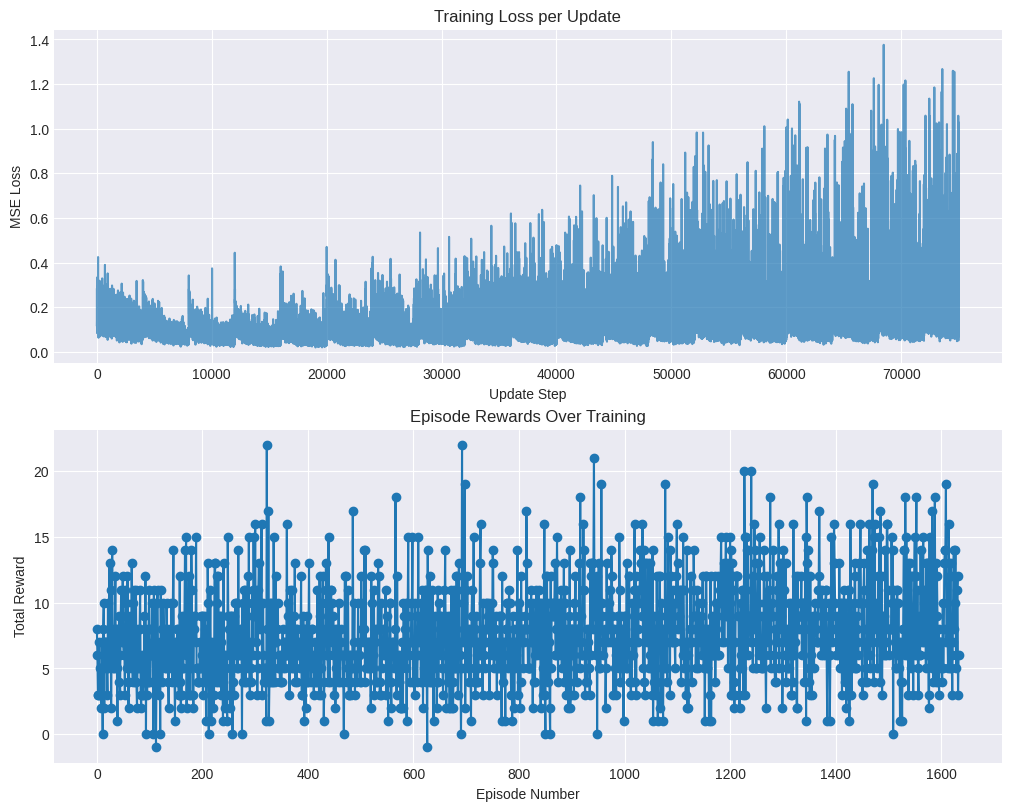

In [6]:



# --- STEP 1: Record ONE greedy episode (RGB) ---
print("Recording ONE episode (greedy)...")

game.close()
game = vzd.DoomGame()
cfg_path = os.path.join(vzd.scenarios_path, "defend_the_line.cfg")
game.load_config(cfg_path)
game.set_window_visible(False)
game.set_screen_format(vzd.ScreenFormat.RGB24)  
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_mode(vzd.Mode.ASYNC_PLAYER)
game.init()

actions = build_actions(game)
frames = []

game.new_episode()
# ensure state exists
while game.get_state() is None:
    game.advance_action()

# initialize frame-stack
frame0 = preprocess(game.get_state().screen_buffer)
stack = collections.deque(maxlen=STACK_SIZE)
state = stack_frames(stack, frame0, is_new=True, stack_size=STACK_SIZE)

FRAME_REPEAT = 8

while not game.is_episode_finished():
    # greedy act
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        action_idx = int(policy_net(s).argmax(dim=1).item())

    game.set_action(actions[action_idx])

    for _ in range(FRAME_REPEAT):
        game.advance_action()
        st = game.get_state()
        if st:
            frame = st.screen_buffer  # RGB HxWx3
            frames.append(frame)

    # next stacked state
    st = game.get_state()
    if st is None:
        break
    f = preprocess(st.screen_buffer)
    state = stack_frames(stack, f, is_new=False, stack_size=STACK_SIZE)

print("Episode recorded. Total frames:", len(frames))

# --- STEP 2: Save MP4 ---
VIDEO_FILENAME = "doom_best_episode.mp4"
writer = imageio.get_writer(VIDEO_FILENAME, fps=20)
for f in frames:
    writer.append_data(f)
writer.close()
print("Saved:", VIDEO_FILENAME)

game.close()

# --- STEP 3: Upload to Google Drive ---


file_drive = drive.CreateFile({'title': VIDEO_FILENAME})
file_drive.SetContentFile(VIDEO_FILENAME)
file_drive.Upload()

print("Upload complete!")
print("Download link:")
print(file_drive['alternateLink'])

# --- STEP 4: Academic Plots ---
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(2,1,figsize=(10,8), constrained_layout=True)

# Loss history
if len(loss_history) > 0:
    axs[0].plot(loss_history, alpha=0.7)
    axs[0].set_title("Training Loss per Update")
    axs[0].set_xlabel("Update Step")
    axs[0].set_ylabel("MSE Loss")
else:
    axs[0].text(0.5,0.5,"No loss history",ha='center')

# Episode rewards
if len(episode_rewards) > 0:
    axs[1].plot(episode_rewards, marker='o')
    axs[1].set_title("Episode Rewards Over Training")
    axs[1].set_xlabel("Episode Number")
    axs[1].set_ylabel("Total Reward")
else:
    axs[1].text(0.5,0.5,"No rewards history",ha='center')

plt.show()


##  Análisis de Resultados del Entrenamiento

###  Comportamiento del *Loss*
El MSE baja al inicio indicando aprendizaje efectivo, pero luego fluctúa fuertemente sin estabilizarse.  

---

###  Recompensa por Episodio
El agente obtiene buenas recompensas ocasionales (≈20), pero con alta variabilidad.  
No existe una tendencia ascendente clara, lo que indica que la política **no se consolidó del todo**.

---

###  Conclusión 
El modelo aprendió a jugar parcialmente, aunque es inconsistente es un buen inicio para la creación de futuros agentes.  

---
